In [ ]:
# import packages used for the problems

import numpy as np #comment: numerical package
import matplotlib.pyplot as plt #comment: plotting package
import corner #comment: to plot corner plots
from scipy import optimize #comment: versatile optimization tool: https://docs.scipy.org/doc/scipy/tutorial/optimize.html
from scipy import interpolate as intpo #comment: https://docs.scipy.org/doc/scipy/reference/interpolate.html
import scipy as sp #comment: collection of mathematical algorithms https://docs.scipy.org/doc/scipy/
from numba import jit #comment: numba optimizes functions for machine runtime. jit is a decorator that tags the function in question https://numba.pydata.org/
import pickle #comment: to save your code and its results as is in a binary format file "*.p".
import time
import emcee  #comment: sampler https://emcee.readthedocs.io/en/stable/ 
from math import pi, e #comment: mathematical constants
import uncertainties
from uncertainties import umath
import pandas as pd #comment: data analysis tool https://pandas.pydata.org/ 
from astropy.table import Table
from multiprocessing import Pool
from IPython.display import Math
import copy
from PyAstronomy.pyTiming import pyPDM
from astropy.timeseries import LombScargle
import pywt



# Solutions to Problem 1

## Solution to 1.1-1.4

In [ ]:
def make_sin_data(f,A,phi,size,dt,sparseness = 0,win_num = 0,win_len = 0,noise = 0):
    rng = np.random.default_rng()
    n = int(size/dt)
    ran_ind = rng.choice(n+1, size= int(sparseness * (n+1)), replace=False)
    windows = rng.choice(n+1, size=win_num, replace=False)
    window_length = int(win_len / dt)
    
    t = np.linspace(0,n*dt,num=n+1)
    
    y = np.zeros(n+1)
                  
    for i,ff in enumerate(f):
        y += A[i] * np.sin(t*ff * 2 * pi + phi[i])
    y += np.random.normal(scale=noise, size = n+1)
    if ran_ind.size!=0:
        y[ran_ind] = np.nan
        
    if win_num!= 0:
        for i in range(win_num):
            y[windows[i]:windows[i]+window_length] = np.nan

    return (t,y)


## Solution to 1.5

In [ ]:
def fft_perio(y, dt):
    fourier = np.fft.fft(np.nan_to_num(y))
    periodogram = (np.abs(fourier))
    n = y.size
    freq = np.fft.fftfreq(n, d=dt)
    freq = np.fft.fftshift(freq)
    periodogram = np.fft.fftshift(periodogram)/np.count_nonzero(~np.isnan(y))*2.

    return (freq,periodogram,periodogram**2.)

def plot_ts(t,y,freq,perio,low,high, ref = False):
    plt.figure(figsize=(23, 3), dpi=80)
    plt.scatter(t, y)
    plt.xlim(low,high)
    plt.show()

    plt.figure(figsize=(23, 3), dpi=80)
    plt.plot(freq, perio)
    if ref != False:
        plt.scatter(ref[0],ref[1], color = 'red')

    plt.xscale('log')
    plt.yscale('log')
    plt.show()

## Solution to 1.6

In [4]:
f = [1/5.0,1/20.0,1/117.36]
A = [5.,30.,15.]
phi = [0.,pi/2., pi]

t1,y1 = make_sin_data(f, A, phi, 5000,0.5, sparseness = 0, win_num = 0, win_len = 35., noise = 0)
freq1, perio1, ps1 = fft_perio(y1, 0.5)


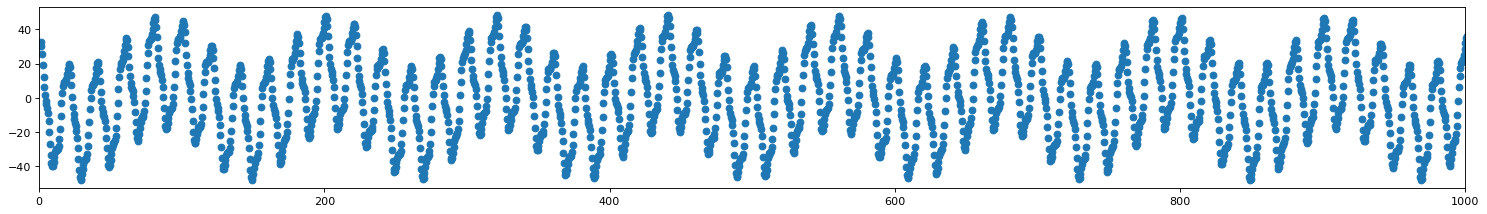

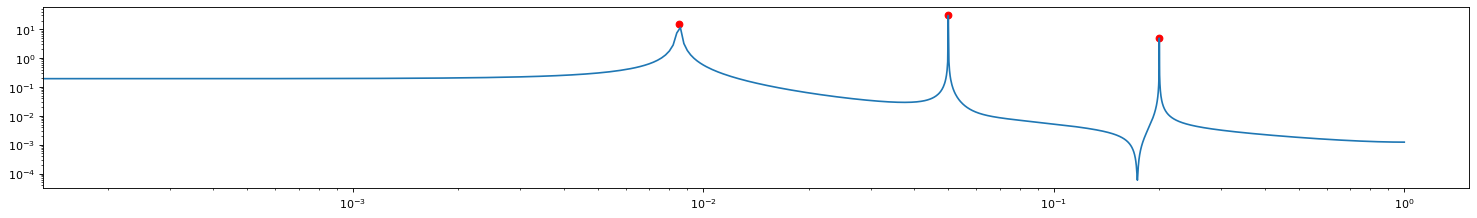

In [5]:
plot_ts(t1,y1,freq1,perio1,0,1000, ref=[f,A])

In [6]:
t2,y2 = make_sin_data(f, A, phi, 5000,0.5, sparseness = 0, win_num = 0, win_len = 35., noise = 2.0)
freq2, perio2, ps2 = fft_perio(y2, 0.5)


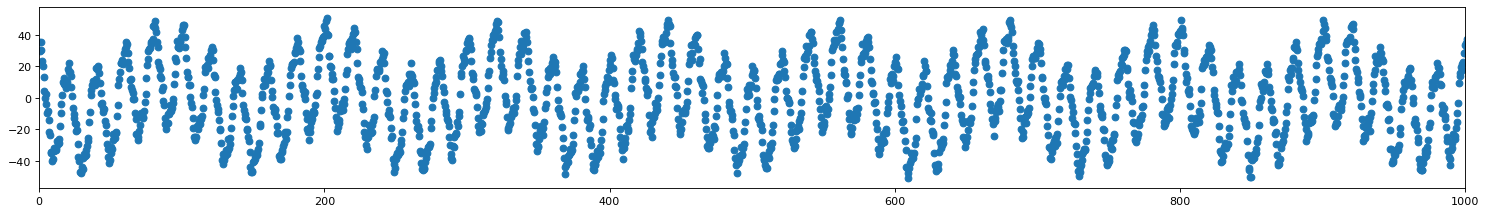

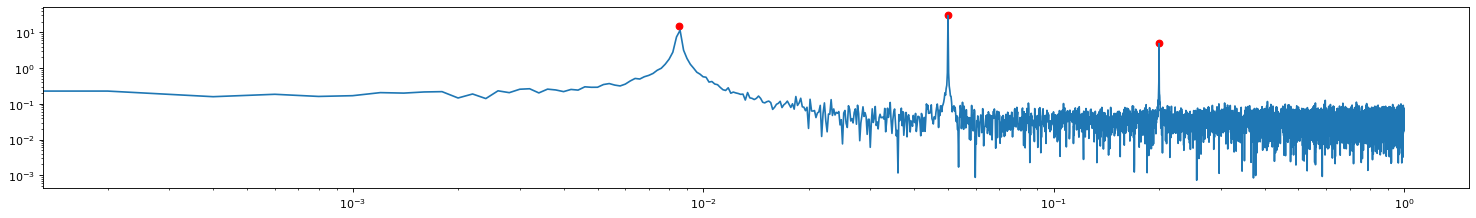

In [7]:
plot_ts(t2,y2,freq2,perio2,0,1000, ref=[f,A])

In [8]:
t3,y3 = make_sin_data(f, A, phi, 5000,0.5, sparseness = 0.7, win_num = 0, win_len = 35., noise = 0.0)
freq3, perio3, ps = fft_perio(y3, 0.5)

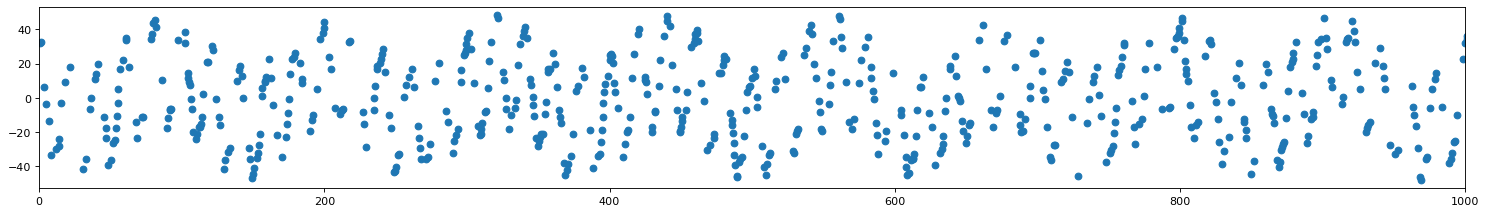

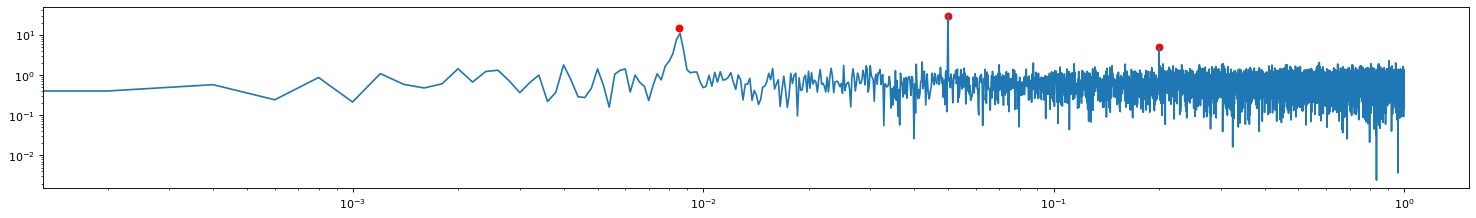

In [9]:
plot_ts(t3,y3,freq3,perio3,0,1000, ref=[f,A])

In [10]:
t4,y4 = make_sin_data(f, A, phi, 5000,0.5, sparseness = 0, win_num = 66, win_len = 35., noise = 0.0)
freq4, perio4, ps4 = fft_perio(y4, 0.5)

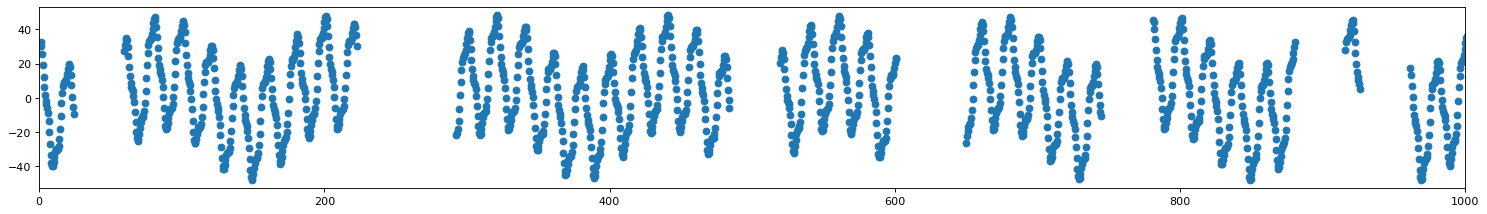

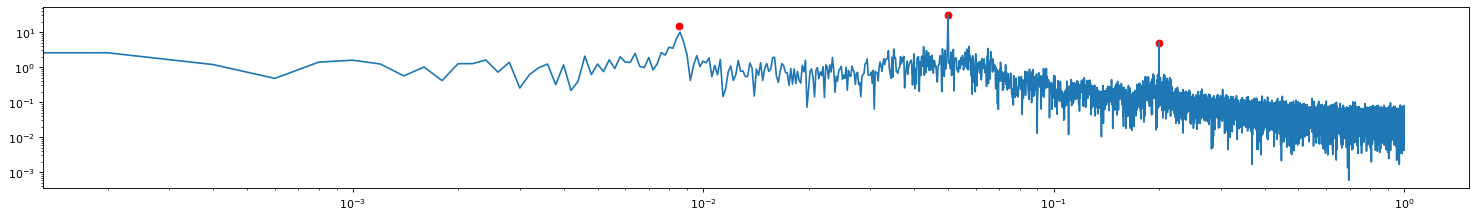

In [11]:
plot_ts(t4,y4,freq4,perio4,0,1000, ref=[f,A])

In [12]:
t5,y5 = make_sin_data(f, A, phi, 5000,0.5, sparseness = 0.8, win_num = 88, win_len = 35., noise = 1.2)
freq5, perio5, ps5 = fft_perio(y5, 0.5)


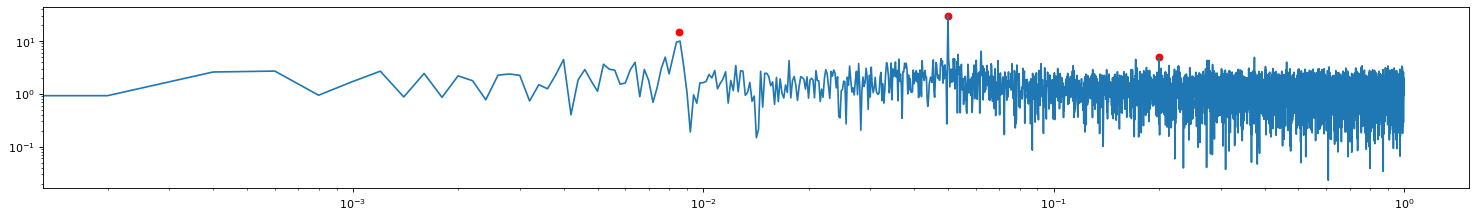

In [13]:
plot_ts(t5,y5,freq5,perio5,0,1000, ref=[f,A])

In [14]:
t6,y6 = make_sin_data(f,A, phi, 500,0.5, sparseness = 0.8, win_num = 5, win_len = 35., noise = 1.2)
freq6, perio6, ps6 = fft_perio(y6, 0.5)

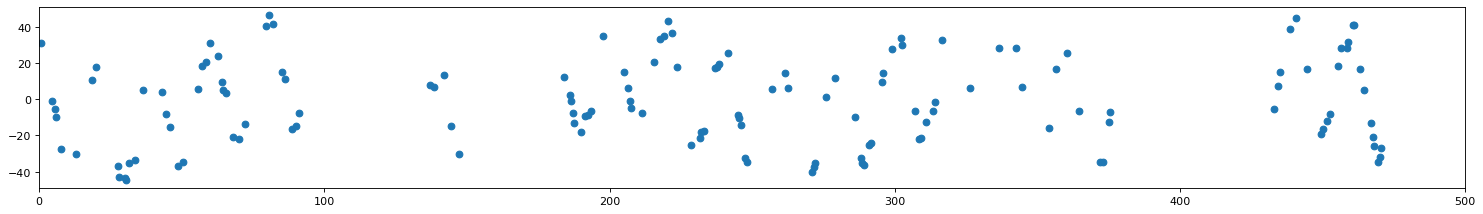

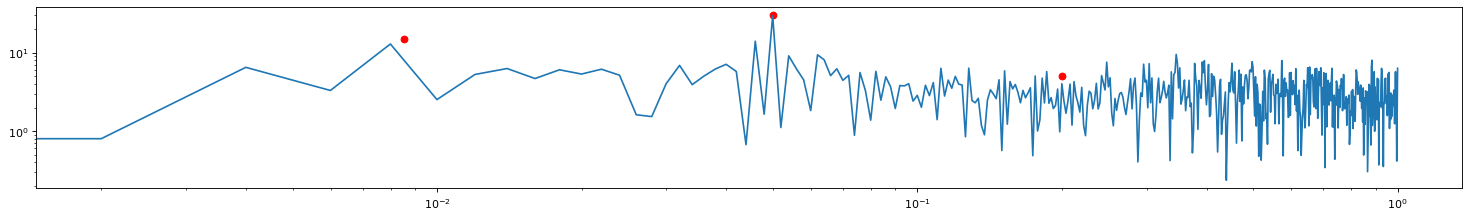

In [15]:
plot_ts(t6,y6,freq6,perio6,0,500, ref=[f,A])

# Solutions to Problem 2

## Solution to 2.3-2.5

In [2]:
class GaussianProcess:
    """
    Class for computing Gaussian random processes from power-law power spectral densities.

        Methods
        ----------
		PowSpec(self, mode)
		RandomGen(self)
		FFTTimeSerie(self, mode)
		Plot(self, x_min, x_max)
    """

    def __init__(self, params, ranClass=None, mode = None):
        """
        Parameters
            ----------
            params : dictionary
                {        "toff": 0.,      				starting time of time series
                      "restime": self.restime, 			observed cadence
                         "samp": 0.1,     				light curve initial sampling
                       "length": 12.0*self.time_int,  	light curve length
                           "a1": 0.0,     				PSD slope for nu<nu_b
                           "a2": self.PSD_slope_fast,   PSD slope for nu_b<nu<nu_b2
                           "a3": self.PSD_slope_fast,   PSD slope for nu_b2<nu
                         "nu_b": self.PSD_break_fast, 	PSD break frequency
                        "nu_b2": 0.05    				PSD break frequency, nu_b2>nu_b
                 }
        Keywords
            ----------
            ranClass : object
                Object with random number attributes, e.g. a instance of GaussianProcess. For
                providing random numbers for computing correlated Gaussian processes.
            mode : string
                None : Gaussian process
                inner_der : derivative of Gaussian process
        """
        self.__dict__.update(params)
        if ranClass is None:
            self.rand1 = None
            self.rand2 = None
            self.rand3 = None
        else:
            self.rand1 = ranClass.rand1
            self.rand2 = ranClass.rand2
            self.rand3 = ranClass.rand3
        self.nnn = int(round(self.length / self.samp)) - (int(round(self.length / self.samp)) % 2)
        self.N = int(self.nnn / 2)
        self.PowSpec(mode)
        self.RandomGen()
        self.FFTTimeSerie(mode)

    def PowSpec(self, mode):
        """
		Method for generating the power spectral density.

        Parameters:
            ----------
            mode : string
                None : Gaussian process
                inner_der : derivative of Gaussian process
        """
        if mode is None:
            self.Max_nu = 1.0 / (self.samp * 2.0)
            self.Min_nu = 1.0 / (self.nnn * self.samp)
            self.freq = np.arange(0, self.N, dtype=np.uint64) * (self.Max_nu - self.Min_nu) \
            			/ (self.N - 1) + self.Min_nu
            self.ind1 = (self.freq < self.nu_b).nonzero()
            self.ind2 = (self.freq >= self.nu_b).nonzero()
            self.ind3 = (self.freq >= self.nu_b2).nonzero()
            self.pow = np.zeros(self.N, dtype=np.float32)
            self.pow[self.ind1] = self.freq[self.ind1] ** (-self.a1) \
            						* self.nu_b ** (self.a1 - self.a2)
            self.pow[self.ind2] = self.freq[self.ind2] ** (-self.a2)
            self.pow[self.ind3] = self.freq[self.ind3] ** (-self.a3) \
            						* self.nu_b2 ** (self.a3 - self.a2)
            self.f = np.arange(0, self.N + 1, dtype=np.double) / (self.nnn * self.samp)
            self.df = self.f[1]-self.f[0]
            self.spec = np.sqrt(intpo.UnivariateSpline(self.freq, self.pow, s=0, k=3)(self.f))
            self.var = np.sqrt(np.sum(4.0*self.spec[1:-2]**2.0) + self.spec[-1]**2.0)
        elif mode == "inner_der":
            self.Max_nu = 1.0 / (self.samp * 2.0)
            self.Min_nu = 1.0 / (self.nnn * self.samp)
            self.freq = np.arange(0, self.N, dtype=np.uint64) * (self.Max_nu - self.Min_nu) \
            			/ (self.N - 1) + self.Min_nu
            self.ind1 = (self.freq < self.nu_b).nonzero()
            self.ind2 = (self.freq >= self.nu_b).nonzero()
            self.ind3 = (self.freq >= self.nu_b2).nonzero()
            self.pow = np.zeros(self.N, dtype=np.float32)
            self.pow[self.ind1] = self.freq[self.ind1] ** (-self.a1) \
            						* self.nu_b ** (self.a1 - self.a2)
            self.pow[self.ind2] = self.freq[self.ind2] ** (-self.a2)
            self.pow[self.ind3] = self.freq[self.ind3] ** (-self.a3) \
            						* self.nu_b2 ** (self.a3 - self.a2)
            self.f = np.arange(0, self.N + 1, dtype=np.double) / (self.nnn * self.samp)
            self.df = self.f[1]-self.f[0]
            self.spec = np.sqrt(intpo.UnivariateSpline(self.freq, self.pow, s=0, k=3)(self.f))
            self.modifier = np.sin(self.f*self.samp*2.0*pi)/self.samp
            self.spec *= self.modifier
            self.var = np.sqrt(np.sum(4.0*self.spec[1:-2]**2.0) + self.spec[-1]**2.0)

    def RandomGen(self):
        """
		Method for generating random numbers.
        """
        if self.rand1 is None:
            self.rand1 = np.random.standard_normal((self.N - 1,))
            self.rand2 = np.random.standard_normal((self.N - 1,))
            self.rand3 = np.random.standard_normal((1,))
        else:
            print('RandomGen: taking provided random numbers')

    def FFTTimeSerie(self, mode):
        """
		Method for generating Gaussian process via FFT from random numbers.

        Parameters:
            ----------
            mode : string
                None : Gaussian process
                inner_der : derivative of Gaussian process
        """
        self.x = np.zeros(2 * self.N, dtype=np.complex128)
        i_train = [i + 1 for i in range(self.N - 1)]
        j_train = [j + self.N + 1 for j in range(self.N - 1)]
        if mode is None:
            for i in i_train:
                self.x[i] = np.complex(self.spec[i] * self.rand1[i-1], self.spec[i] \
                			* self.rand2[i-1])
            self.x[self.N] = np.complex(self.spec[self.N] * self.rand3, 0.0)
            for j in j_train:
                self.x[j] = np.conj(self.x[2 * self.N - j])
            self.x = np.double(np.real(np.fft.fft(self.x)))
            self.x /= self.var
            self.time = np.double(np.arange(0, self.nnn, dtype=np.uint64) * self.samp) + self.toff
            self.x_res = np.interp(self.restime,self.time,self.x)
        else:
            for i in i_train:
                self.x[i] = np.complex(self.spec[i] * self.rand2[i-1], -self.spec[i] \
                			* self.rand1[i-1])
            self.x[self.N] = np.complex(0.0, self.spec[self.N] * self.rand3)
            for j in j_train:
                self.x[j] = np.conj(self.x[2 * self.N - j])
            self.x = np.double(np.real(np.fft.fft(self.x)))
            self.x /= self.var
            self.time = np.double(np.arange(0, self.nnn, dtype=np.uint64) * self.samp) + self.toff
            self.x_res = np.interp(self.restime,self.time[1:-1],self.x[1:-1])

class LightCurves:
    """
    Class for computing light curves with via non-linear transformations from Gaussian processes.

        Methods
        ----------
        LognTrans(self)
        PowerLawTrans(self)
        Plot(self, _time, x_min, x_max, plotNoise = False)
        Derivative(self)
        lambda_loop(self, a, _gamma, B0, f0_B, theta0, f0_theta, df = None)
    """

    def __init__(self, params, GaussianPrClass):
        """
        Parameters
            ----------
            params : dictionary
                {     "mode": "logn",            transformation mode (string, logn or powerlaw)
                      "par1": self.mu_fast, 	 transformation parameter (e.g., mu)
                      "par2": self.sig_fast,     transformation parameter (e.g.,sigma)
                    "offset": 0.0,               flux density offset
                       "fac": 1.,                scaling factor
                "noise_mode": "gauss",           noise mode (string, gauss or poisson)
                     "noise": 0.0003             noise parameter
                }
            GaussianPrClass : object
                Instance of class GaussianProcess.
        """
        self.__dict__.update(params)
        self.x = GaussianPrClass.x
        self.time = GaussianPrClass.time
        self.const = constants()
        if self.mode == "logn":
            self.LognTrans()
        if self.mode == "powerlaw":
            self.PowerLawTrans()
        if self.mode == "radmod":
            self.RadMod()
        self.dflux = None
        self.restime = None

    def LognTrans(self):
        """
		Method for generating log-normally distributed flux densities.
        """
        self.flux = self.fac * np.exp(self.x * self.par2 + self.par1) + self.offset
        if self.noise_mode == "gauss":
            self.flux_noise = self.flux + self.noise * np.random.standard_normal((self.flux.size,))
        if self.noise_mode == "poisson":
            self.flux_noise = np.random.poisson((1.0/(3.933*self.flux**(-0.03541) \
            					+ 0.6564*self.flux**(-1.107))) * 60.)/60.

    def PowerLawTrans(self):
        """
		Method for generating power-law distributed flux densities.
        """
        self.flux = sp.special.erf(self.x / np.sqrt(2.))
        self.corr = 1. / ((3000. / (-self.par1)) ** (self.par2 - 1.) - 1.)
        _exp = 1. / (1. - self.par2)
        self.flux = self.fac * (-self.par1) * ((0.5 * (1. + self.flux) + self.corr) \
        			/ (1. + self.corr)) ** _exp + self. offset
        if self.noise_mode == "gauss":
            self.flux_noise = self.flux + self.noise * np.random.standard_normal((self.flux.size,))
        if self.noise_mode == "poisson":
            self.flux_noise = np.random.poisson((1.0/(3.933*self.flux**(-0.03541) \
            					+ 0.6564*self.flux**(-1.107))) * 60.)/60.



## Solution to 2.6

In [ ]:
def make_random_process(a2, a3, b, b2, size, dt):
    n = int(size/dt)
    restime = np.linspace(0,n*dt,num=n+1)
    params = {        "toff": 0.,      \
                            "restime": restime, \
                               "samp": dt,     \
                             "length": size,  \
                                 "a1": 0.0,     \
                                 "a2": a2,     \
                                 "a3": a3,     \
                               "nu_b": b, \
                              "nu_b2": b2    \
                    }
    gp = GaussianProcess(params)
    return (gp.restime, gp.x_res)
        

In [16]:
a2 = 3.0
a3 = 6.5
b = 1/145.
b2 = 1/20.

t7,y7 = make_random_process(a2, a3, b, b2, 5000, 0.5)
freq7, perio7, ps7 = fft_perio(y7, 0.5)

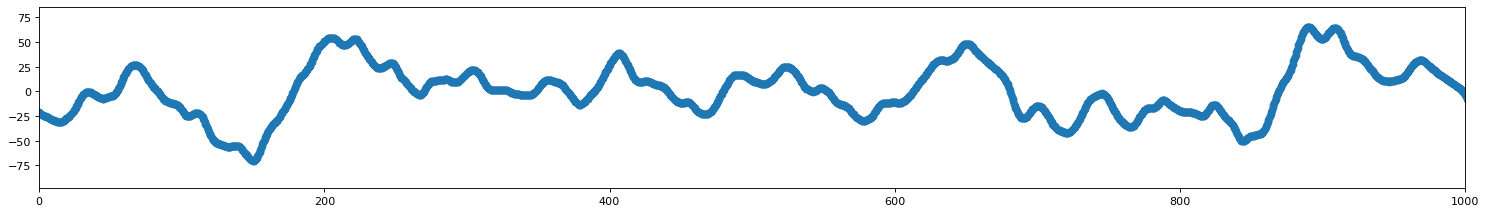

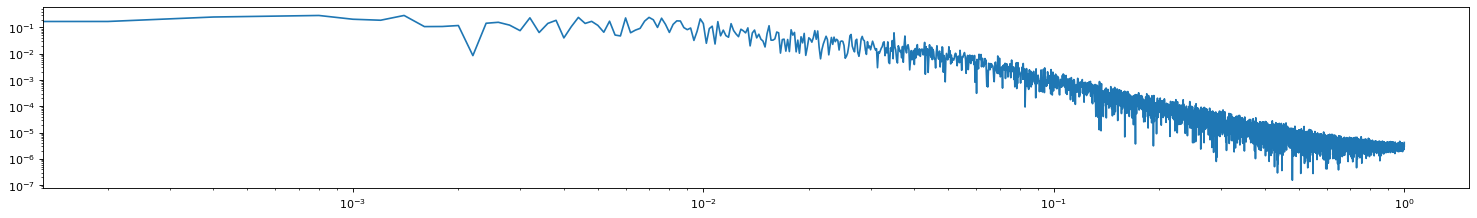

In [17]:
plot_ts(t7,30.*y7,freq7,perio7,0,1000)

In [18]:
y8 = 30.*y7 + y5
freq8, perio8, ps8 = fft_perio(y8, 0.5)

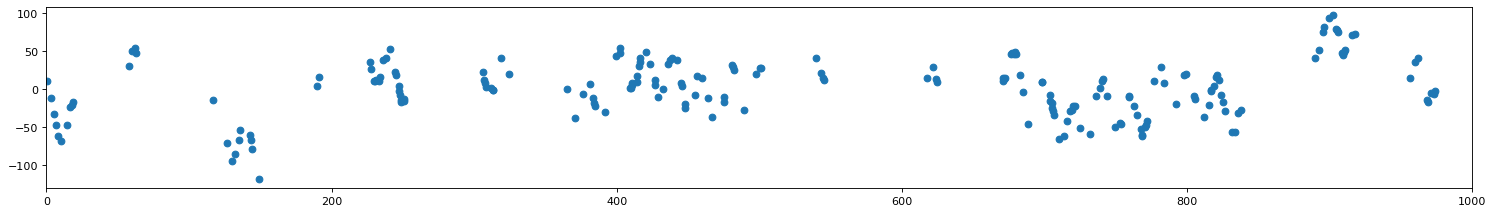

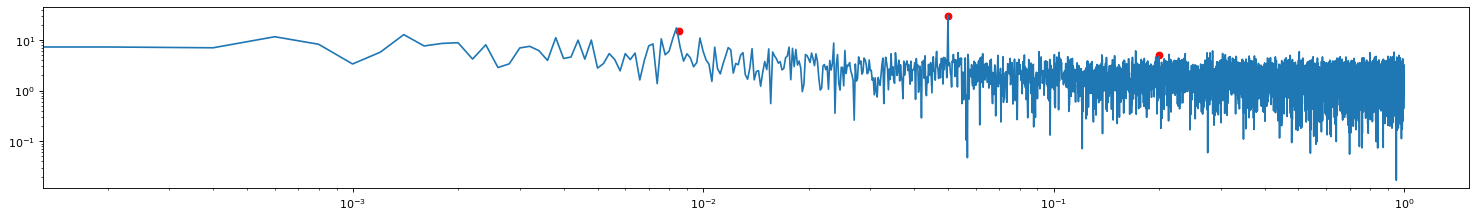

In [19]:
plot_ts(t7,y8,freq8,perio8,0,1000, ref=[f,A])

In [20]:
t9,y9 = make_random_process(a2, a3, b, b2, 500, 0.5)
freq9, perio9, ps9 = fft_perio(y9, 0.5)

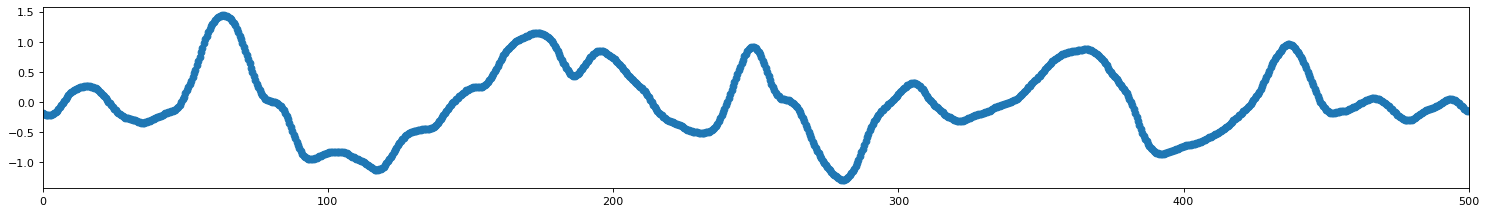

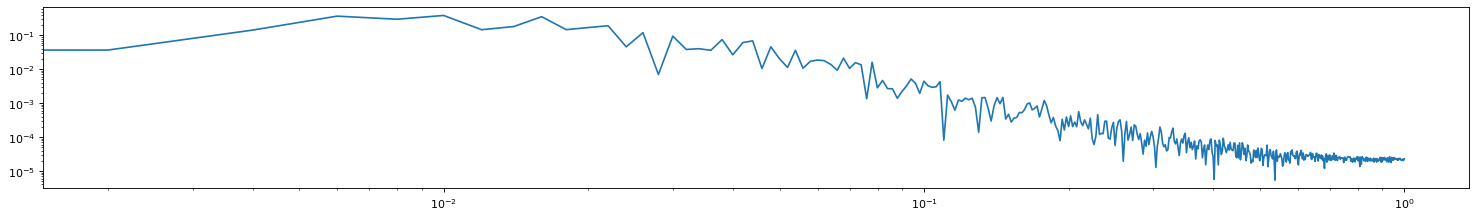

In [21]:
plot_ts(t9,y9,freq9,perio9,0,500)

In [22]:
y10 = 30.*y9 + y6
freq10, perio10, ps10 = fft_perio(y10, 0.5)

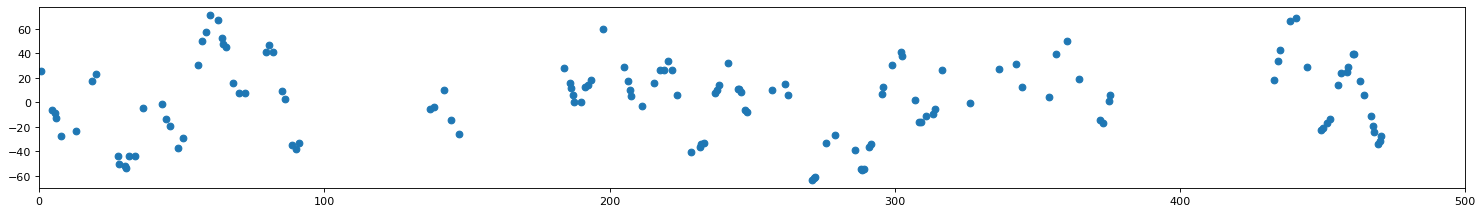

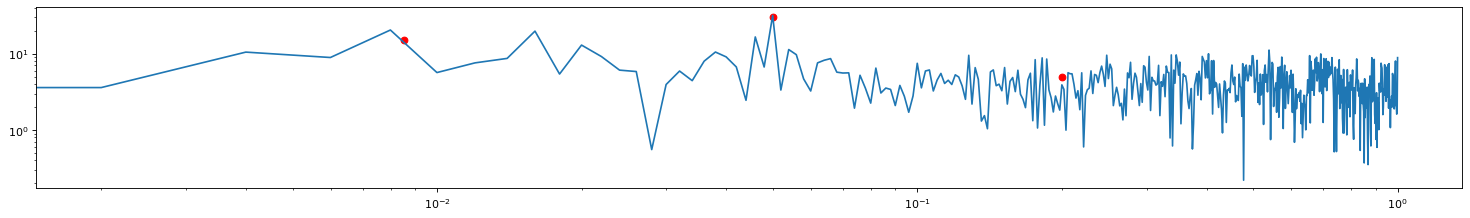

In [23]:
plot_ts(t9,y10,freq10,perio10,0,500, ref=[f,A])

# Solutions to Problem 3

## Solution to 3.1

In [208]:
f = [1/5.0,1/20.0,1/117.36]
A = [30.,30.,30.]
phi = [0.,pi/2., pi]

t,y = make_sin_data(f, A, phi, 5000,0.1, sparseness = 0, win_num = 0, win_len = 35., noise = 3.)

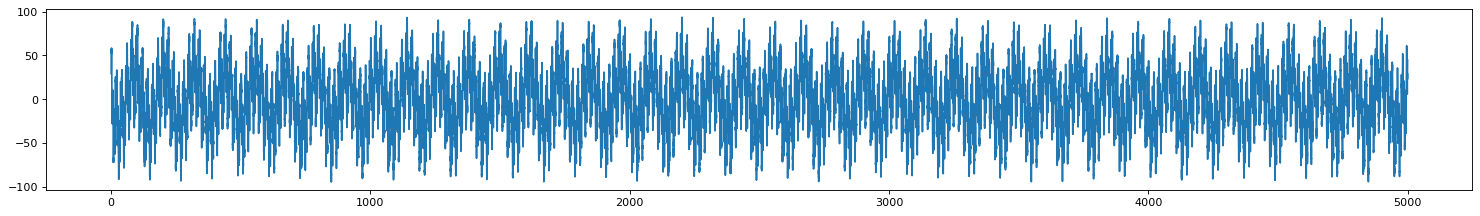

In [209]:
plt.figure(figsize=(23, 3), dpi=80)
plt.plot(t,y)
plt.show()

## Solution to 3.2

In [184]:
def PDM_ts(t,y,minVal=1.0, maxVal=10., dVal=0.1, mode = 'period'):
    _S = pyPDM.Scanner(minVal=minVal, maxVal=maxVal, dVal=dVal, mode=mode)
    P = pyPDM.PyPDM(t, y)
    return P.pdmEquiBin(15, _S)

In [213]:
phase_dis = PDM_ts(t1,y1,minVal=0.0002, maxVal=0.3, dVal=0.00001, mode = 'frequency')

In [211]:
print(f)

[0.2, 0.05, 0.008520790729379687]


## Solution to 3.3

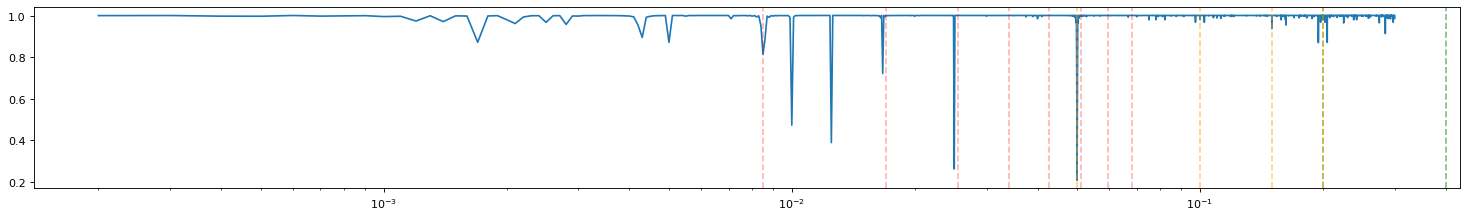

In [212]:
plt.figure(figsize=(23, 3), dpi=80)
plt.plot(phase_dis[0],phase_dis[1])
plt.xscale('log')
for i in range(2):
    plt.axvline(x=(i+1)*f[0], color = 'green', alpha = 0.5, ls = '--')
for i in range(4):
    plt.axvline(x=(i+1)*f[1], color = 'orange', alpha = 0.5, ls = '--')
for i in range(8):
    plt.axvline(x=(i+1)*f[2], color = 'red', alpha = 0.3, ls = '--')
plt.show()

In [190]:
def phase_ts(t,y,period):
    P = pyPDM.PyPDM(t, y)
    phase, index = P.phase(t, period)
    return (phase[index], y[index])

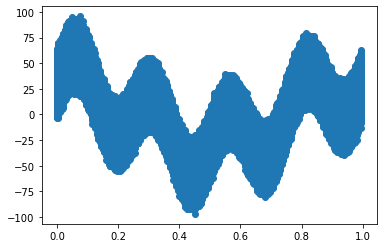

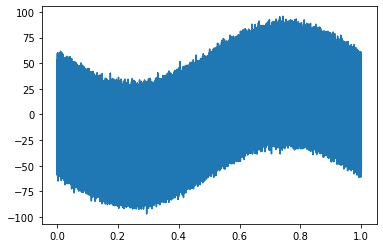

In [191]:
phase, y_folded = phase_ts(t,y,20.0)
plt.scatter(phase,y_folded)
plt.show()

phase, y_folded = phase_ts(t,y,5.0)
plt.scatter(phase,y_folded)
plt.show()

phase, y_folded = phase_ts(t,y,117.36)
plt.plot(phase,y_folded)
plt.show()

# Solutions to Problem 4

## Solution to Problem 4.1

In [160]:
def AR1(init = 0, a=0.1,mu=0,sig=1):

    eps = np.random.normal(loc = mu, scale = sig, size = 100000)
    mark=np.zeros(100000)
    mark[0] = init

    for i in range(1,100000):
        mark[i] = a*mark[i-1]+eps[i]
    return mark

## Solution to Problem 4.2

In [216]:
init = 20.
mu = 1.0
sig = 1.0
a = 0.9
mark = AR1(init = init, a=a, mu = mu, sig = sig)

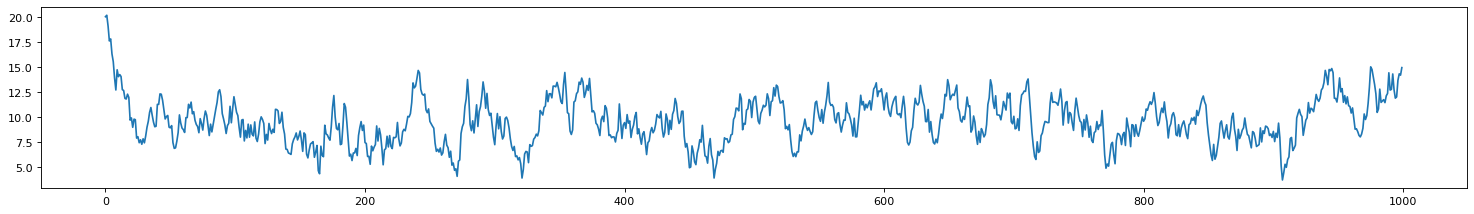

In [217]:
plt.figure(figsize=(23, 3), dpi=80)
plt.plot(mark[:1000])
plt.show()

## Solution to Problem 4.3

In [178]:
print(np.mean(mark), mu/(1-a))

10.028020078168147 10.000000000000002


In [179]:
print(np.var(mark), sig**2./(1-a**2.))

5.2232403997613375 5.263157894736843


In [180]:
def autocorr(x, twosided=False, tapered=True):
    """
    Return (lags, ac), where ac is the estimated autocorrelation 
    function for x, at the full set of possible lags.
    
    If twosided is True, all lags will be included;
    otherwise (default), only non-negative lags will be included.

    If tapered is True (default), the low-MSE estimate, linearly
    tapered to zero for large lags, is returned.
    """
    nx = len(x)
    xdm = x - x.mean()
    ac = np.correlate(xdm, xdm, mode='full')
    ac /= ac[nx - 1]
    lags = np.arange(-nx + 1, nx)
    if not tapered:  # undo the built-in taper
        taper = 1 - np.abs(lags) / float(nx)
        ac /= taper
    if twosided:
        return lags, ac
    else:
        return lags[nx-1:], ac[nx-1:]


In [181]:
c = autocorr(mark)

In [182]:
plt.figure(figsize=(23, 3), dpi=80)
plt.plot(c[0][:100], c[1][:100])
plt.plot(c[0][:100],a**(c[0][:100]))
plt.show()

# Solutions to Problem 5

In [192]:
def schuster_periodogram(t, mag, freq):
    t, mag, freq = map(np.asarray, (t, mag, freq))
    return abs(np.dot(mag, np.exp(-2j * np.pi * freq * t[:, None])) / np.sqrt(len(t))) ** 2

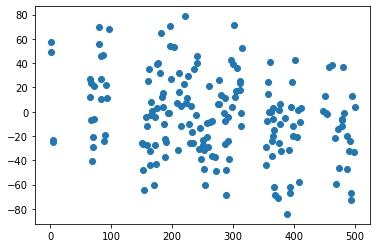

In [193]:
t12,y12 = make_sin_data(f,A, phi, 500,0.5, sparseness = 0.7, win_num = 8, win_len = 35., noise = 3.2)
plt.scatter(t12,y12)
plt.show()

In [194]:
freq, p_ls = LombScargle(t12, np.nan_to_num(y12)).autopower(minimum_frequency=0.001,
                                         maximum_frequency=1.0,
                                         normalization='psd',
                                         samples_per_peak=5)
p_schuster = schuster_periodogram(t12, np.nan_to_num(y12), freq)


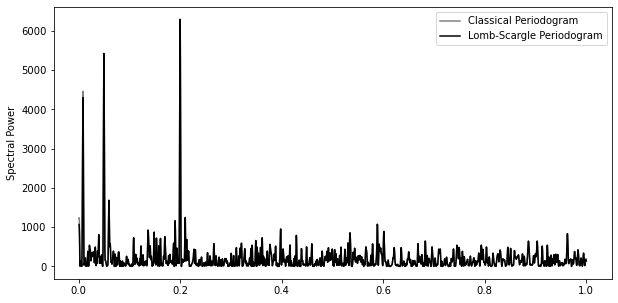

In [195]:
fig, ax = plt.subplots(1, figsize=(10, 5), sharex=True)
ax.plot(freq, p_schuster, '-', color='gray', label='Classical Periodogram')
ax.plot(freq, p_ls, '-k', label='Lomb-Scargle Periodogram')
ax.legend();
ax.set(ylabel='Spectral Power')

plt.show()
